In [45]:
# import libraries:
import pandas as pd
from datetime import (datetime,timedelta)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def create_dt(df_, column='timestamp'):
    
    df_[column] = pd.to_datetime(df_[column])
    
    df_['day'] = df_[column].dt.day
    
    return df_

def make_checkout(df_):
    check_out = df_.loc[df_.location=='checkout']['customer_no'].unique()
    
    no_check_out = df_[~df_['customer_no'].isin(check_out)]['customer_no'].unique()
    
    day = df_.loc[df_.index == 0]['day'].values[0]
    
    new_list = []
    
    for customer in no_check_out:
        new_row = {'timestamp':f'2019-09-{day} 21:51:00',
                   'customer_no':customer,
                   'location':'checkout',
                   'day':day
                  }
    
        new_obs = pd.DataFrame(new_row, index=[1])
        new_list.append(new_obs)
        
    
    test_df = pd.concat(new_list) 
    
    test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
    
    df_ = pd.concat([df_,test_df], ignore_index=True, axis=0)
    
    return df_

def entrance(df_):
    df_test = (df_
               .groupby('new_id')[['timestamp']]
               .first()
               .transform(lambda x: x - timedelta(minutes=1))
               .reset_index())
    
    df_test['location'] = 'entrance'
    
    df_combined = pd.concat([df_[['new_id','timestamp','location']], df_test], ignore_index=True)
    
    df_combined.sort_values(['new_id','timestamp'])
    
    return df_combined



def resample(df_):
    grouped = df_.groupby('new_id')
    
    resample_function = lambda x: x.set_index('timestamp').resample('1T').ffill().reset_index()
    
    resampled_df = pd.concat([resample_function(group) for name, group in grouped])
    
    df_ = resampled_df
    
    df_['shifted'] = df_.groupby('new_id')['location'].shift(-1).fillna('checkout')
    
    return df_

def load_and_combining(files, file_type="csv"):
    """This function implements automatization for loading the csv files into dataframes and 
    combines all of them into one 
    
    Args:
    files (list): a list of all file present in this directory
    file_type (str, default value): the file 
    
    Return:
    df_combined (dataframe): a concated df of all year
    """
    

    # Define an empty list
    all_df = []
    
    
    # Iterate trough the list FILES
    for file in files:
        # Pick only the file ending with csv 
        if file.endswith(file_type):
            
            print(file)
            
            # load this file into a dataframe
            df = pd.read_csv(file, sep=';')
            
            df = create_dt(df)
            
            df = make_checkout(df)
            
            df['new_id'] = (df['day']).astype(str) + "_" + (df['customer_no']).astype(str)
            
            df = entrance(df)
            
           # df = resample(df)
            
            all_df.append(df)
    
    
    # Combine all_df
            
    df_combined = pd.concat(all_df, axis=0, ignore_index=True)
    df_combined = df_combined.sort_values(['timestamp', 'new_id']).reset_index(drop=True)
    
    # df_resampled = resample(df_combined)
    
    return df_combined


In [46]:
FILES = ('../data/tuesday.csv', 
         '../data/monday.csv', 
         '../data/thursday.csv', 
         '../data/wednesday.csv', 
         '../data/friday.csv'
)

df = load_and_combining(FILES)
df

tuesday.csv
monday.csv
thursday.csv
wednesday.csv
friday.csv


,new_id,timestamp,location
0,2_1,2019-09-02 07:02:00,entrance
1,2_2,2019-09-02 07:02:00,entrance
2,2_1,2019-09-02 07:03:00,dairy
3,2_2,2019-09-02 07:03:00,dairy
4,2_3,2019-09-02 07:03:00,entrance
...,...,...,...
32345,6_1503,2019-09-06 21:51:00,checkout
32346,6_1505,2019-09-06 21:51:00,checkout
32347,6_1506,2019-09-06 21:51:00,checkout
32348,6_1509,2019-09-06 21:51:00,checkout


In [47]:
# Create a new column for the day of the week
df['day'] = pd.to_datetime(df['timestamp']).dt.day_name()
data = df

In [48]:
# Save the updated data to a new CSV file
# data.to_csv('eda_data.csv', index=False)

### Calculate the total number of customers in each section:

In [49]:
# Calculate the total number of customers in each section
total_customers = data.groupby('location')['new_id'].nunique()
print('Total number of customers in each section across all days:')
print(total_customers)


Total number of customers in each section across all days:
location
checkout    7445
dairy       3818
drinks      3214
entrance    7445
fruit       4284
spices      2938
Name: new_id, dtype: int64


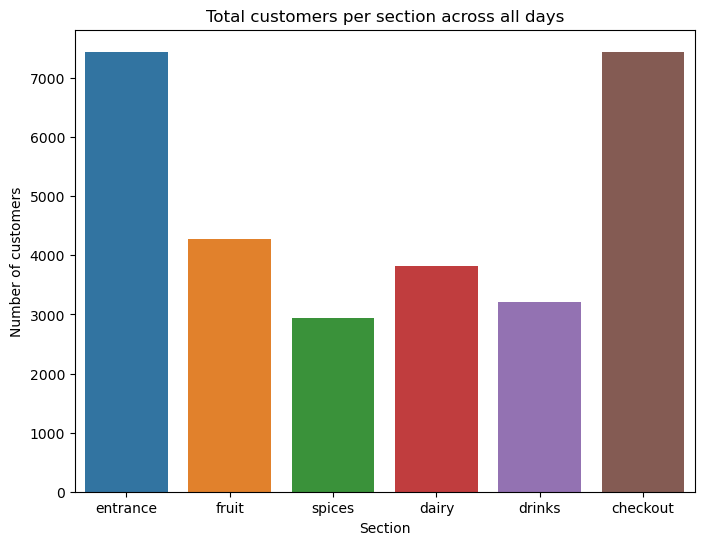

In [50]:
# Total customers per section across all days
location_order = ['entrance', 'fruit', 'spices', 'dairy', 'drinks', 'checkout']

plt.figure(figsize=(8, 6))
sns.barplot(x=total_customers.index, y=total_customers.values, order=location_order)
plt.title('Total customers per section across all days')
plt.xlabel('Section')
plt.ylabel('Number of customers')
plt.show()

### Calculate the total number of customers in each section for each day:

In [51]:
# Calculate the total number of customers in each section for each day:
dayly_section_counts = df.groupby(['day', 'location'])['new_id'].nunique()
print('Total number of customers in each section:')
print(dayly_section_counts)


Total number of customers in each section:
day        location
Friday     checkout    1510
           dairy        761
           drinks       688
           entrance    1510
           fruit        874
           spices       633
Monday     checkout    1447
           dairy        720
           drinks       661
           entrance    1447
           fruit        827
           spices       584
Thursday   checkout    1535
           dairy        782
           drinks       632
           entrance    1535
           fruit        872
           spices       613
Tuesday    checkout    1422
           dairy        751
           drinks       581
           entrance    1422
           fruit        827
           spices       543
Wednesday  checkout    1531
           dairy        804
           drinks       652
           entrance    1531
           fruit        884
           spices       565
Name: new_id, dtype: int64


<module 'matplotlib.pyplot' from '/Users/mykolawauer/opt/anaconda3/envs/scikit_env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

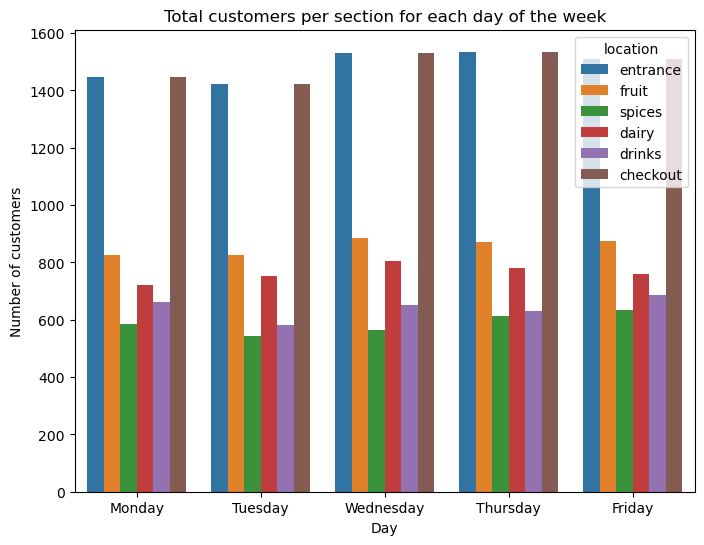

In [52]:
# Create a barplot showing the total customers per section for each day
dayly_section_counts = df.groupby(['day', 'location'])['new_id'].nunique().reset_index(name='count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
plt.figure(figsize=(8, 6))
sns.barplot(x='day', y='count', hue='location', data=dayly_section_counts, order=day_order, hue_order=location_order)
plt.title('Total customers per section for each day of the week')
plt.xlabel('Day')
plt.ylabel('Number of customers')
plt


### Display the number of customers at checkout over time

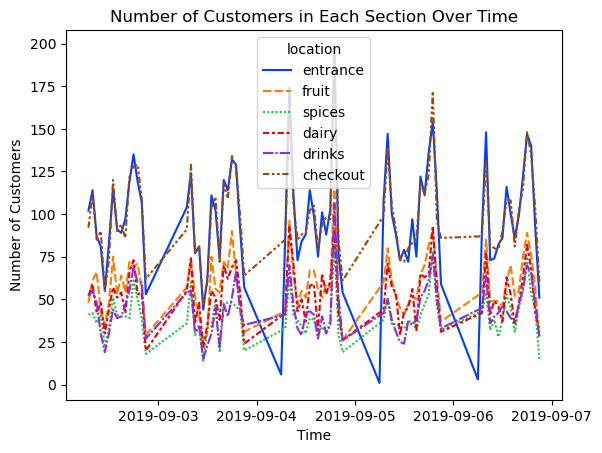

In [53]:
# group the data by location and hourly timestamp
section_counts_over_time = data.groupby([pd.Grouper(key='timestamp', freq='H'), 'location'])['new_id'].nunique().unstack()

# reorder the columns to match 
section_counts_over_time = section_counts_over_time[location_order]

# create a line plot of the total number of customers in each section over time
sns.lineplot(data=section_counts_over_time, palette='bright')
plt.title('Number of Customers in Each Section Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Customers')
plt.show()


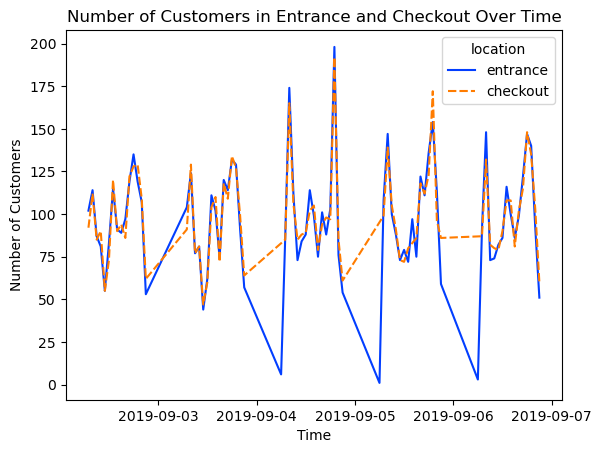

In [54]:
section_counts_over_time = section_counts_over_time[['entrance', 'checkout']]
sns.lineplot(data=section_counts_over_time, palette='bright')
plt.title('Number of Customers in Entrance and Checkout Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Customers')
plt.show()

### Calculate the time each customer spent in the market

Mean time spent in the market: 7.25 minutes
Median time spent in the market: 5.00 minutes


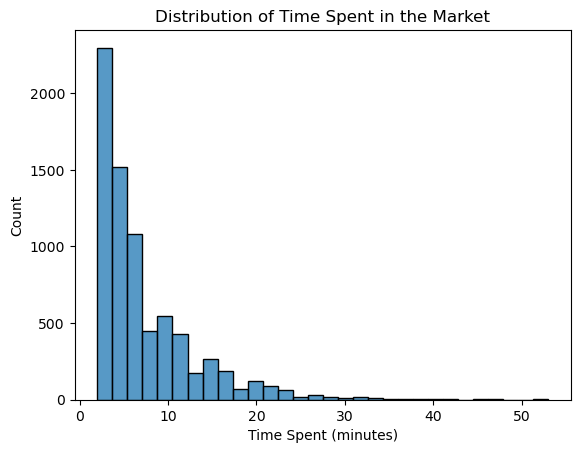

In [55]:
# Calculate the time each customer spent in the market
customer_times = data.groupby('new_id')['timestamp'].apply(lambda x: x.max() - x.min())
customer_times = customer_times.dt.total_seconds() / 60 # dt stands for datetime
# Display the results
print('Mean time spent in the market: {:.2f} minutes'.format(customer_times.mean()))
print('Median time spent in the market: {:.2f} minutes'.format(customer_times.median()))

# Plot a histogram of the customer times
sns.histplot(data=customer_times, bins=30)
plt.title('Distribution of Time Spent in the Market')
plt.xlabel('Time Spent (minutes)')
plt.ylabel('Count')
plt.show()

### Calculate the total number of customers in the supermarket over time.

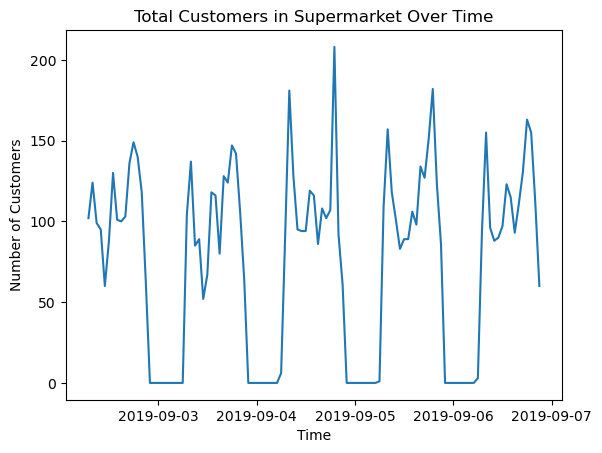

In [58]:
sns.lineplot(data=total_customers_over_time)
plt.title('Total Customers in Supermarket Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Customers')
plt.show()

### Estimate the total revenue

In [60]:

# estimate the total revenue for a customer
revenue_per_minute = {'fruit': 4, 'spices': 3, 'dairy': 5, 'drinks': 6}
data['revenue_per_minute'] = data['location'].map(revenue_per_minute)
customer_revenue = data.groupby('new_id')['revenue_per_minute'].sum() * (customer_times / 60)

# determine the most profitable section
revenue_by_section = data.groupby('location')['revenue_per_minute'].sum()
most_profitable_section = revenue_by_section.idxmax()

print(f"The most profitable section is {most_profitable_section} with total revenue of {revenue_by_section[most_profitable_section]}€.")


The most profitable section is drinks with total revenue of 23430.0€.
